# Master Thesis - Vignoli Lorenzo

---

## 🐙 Helyx training

## ⚙️ Import Libraries

In [1]:
# Libraries
import os
import glob
import random
import warnings
import numpy as np # type: ignore
from PIL import Image # type: ignore
from datetime import datetime
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore

import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
from torchvision import models, transforms # type: ignore
import torch.nn.functional as F # type: ignore
import shutil
import plotly.graph_objects as go # type: ignore
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR, ReduceLROnPlateau # type: ignore

import matplotlib.pyplot as plt # type: ignore
import random
import sys
import cv2
from torch.amp import GradScaler, autocast # type: ignore

warnings.filterwarnings("ignore")
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## ⏳ Load and process the Data

In [2]:
class ColorJitter:
    def __init__(self, brightness=0.6, contrast=0.6, saturation=0.6, mask_extractor=None):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.extractor = mask_extractor

    def __call__(self, img):
        original = img.copy()
        h, w = img.shape[:2]

        if self.extractor is not None:
            img_float = img.astype(np.float32) / 255.0
            tensor = torch.from_numpy(img_float.transpose(2, 0, 1)).unsqueeze(0)
            with torch.no_grad():
                masks = self.extractor(tensor)[0].numpy().transpose(1, 2, 0)
            marker_mask = (masks.sum(axis=2) > 0).astype(np.uint8)[:, :, None]
        else:
            marker_mask = np.zeros((h, w, 1), dtype=np.uint8)

        img = img.astype(np.float32)

        if self.brightness > 0:
            factor = random.uniform(1 - self.brightness, 1 + self.brightness)
            img = img * factor

        if self.contrast > 0:
            mean = img.mean(axis=(0, 1), keepdims=True)
            factor = random.uniform(1 - self.contrast, 1 + self.contrast)
            img = (img - mean) * factor + mean

        if self.saturation > 0:
            gray = img @ [0.2989, 0.5870, 0.1140]
            gray = np.expand_dims(gray, axis=2)
            factor = random.uniform(1 - self.saturation, 1 + self.saturation)
            img = img * factor + gray * (1 - factor)

        img = np.clip(img, 0, 255)

        img = marker_mask * original + (1 - marker_mask) * img
        return img.astype(np.uint8)

class GaussianNoise:
    def __init__(self, mean=0.0, std=8.0):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        noise = np.random.normal(self.mean, self.std, img.shape)
        img = img.astype(np.float32) + noise
        img = np.clip(img, 0, 255).astype(np.uint8)
        return img
    
class GaussianBlur:
    def __init__(self, p=0.5, ksize_range=(3, 7)):
        self.p = p
        self.ksize_range = ksize_range

    def __call__(self, img):
        if random.random() < self.p:
            k = random.choice(range(self.ksize_range[0], self.ksize_range[1] + 1, 2))
            img = cv2.GaussianBlur(img, (k, k), 0)
        return img
    
class ColorMaskAug(nn.Module):
    def __init__(self):
        super().__init__()

    def rgb_to_hsv(self, x):
        r, g, b = x[:, 0], x[:, 1], x[:, 2]
        maxc, _ = x.max(dim=1)
        minc, _ = x.min(dim=1)
        v = maxc
        eps = 1e-8

        deltac = maxc - minc
        s = deltac / (maxc + eps)
        s[maxc == 0] = 0

        rc = (maxc - r) / (deltac + eps)
        gc = (maxc - g) / (deltac + eps)
        bc = (maxc - b) / (deltac + eps)

        h = torch.zeros_like(maxc)
        h[maxc == r] = (bc - gc)[maxc == r]
        h[maxc == g] = 2.0 + (rc - bc)[maxc == g]
        h[maxc == b] = 4.0 + (gc - rc)[maxc == b]
        h = (h / 6.0) % 1.0
        h[deltac == 0] = 0.0

        return torch.stack([h, s, v], dim=1)

    def forward(self, x):
        hsv = self.rgb_to_hsv(x)
        h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]

        green = ((h > 0.25) & (h < 0.45) & (s > 0.3) & (v > 0.2)).unsqueeze(1).float()
        blue  = ((h > 0.55) & (h < 0.75) & (s > 0.3) & (v > 0.2)).unsqueeze(1).float()
        black = (v < 0.3).unsqueeze(1).float()

        return torch.cat([green, black, blue], dim=1)
    
# Definition of augmentations
color_jitter = ColorJitter(mask_extractor=ColorMaskAug())
gaussian_noise = GaussianNoise()
gaussian_blur = GaussianBlur()

In [ ]:
# Saving original images with augmentations
if False:

    # Remove existing folders
    for split in ["train", "val", "test"]:
        shutil.rmtree(f"images/{split}", ignore_errors=True)
        shutil.rmtree(f"labels/{split}", ignore_errors=True)
        os.makedirs(f"images/{split}", exist_ok=True)
        os.makedirs(f"labels/{split}", exist_ok=True)

    dataset_files = sorted(glob.glob("Dataset*.npz"))

    # Compute total number of images
    total_originals = sum([np.load(f)["X_images"].shape[0] for f in dataset_files])
    all_indices = np.arange(total_originals)

    # Split train, validation, test (80-10-5 %)
    train_idx, temp_idx = train_test_split(all_indices, test_size=0.12, random_state=seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=1/3, random_state=seed)

    split_map = np.full(total_originals, "", dtype=object)
    split_map[train_idx] = "train"
    split_map[val_idx] = "val"
    split_map[test_idx] = "test"

    global_index = {
        "train": 0,
        "val": 0,
        "test": 0
    }

    current_idx = 0

    for file in dataset_files:

        print(f"\n Processing {file}...")
        data = np.load(file)
        X_images = data["X_images"]
        y = data["y"]

        for i in range(len(X_images)):

            split = split_map[current_idx]
            assert split in {"train", "val", "test"}

            base_image = X_images[i]
            base_label = y[i]

            image_tensor = torch.from_numpy(base_image).permute(2, 0, 1).to(torch.float32)
            image_tensor = F.interpolate(image_tensor.unsqueeze(0), scale_factor=0.5, mode='bilinear', align_corners=False).squeeze(0).to(torch.uint8)
            label_tensor = torch.from_numpy(base_label).to(torch.float32)

            idx_str = f"{global_index[split]:06d}"
            torch.save(image_tensor, f"images/{split}/img_{idx_str}.pt")
            torch.save(label_tensor, f"labels/{split}/label_{idx_str}.pt")
            global_index[split] = global_index[split] + 1

            # Augmentation only if training
            if split == "train":
                for _ in range(2):
                    aug_image = base_image.copy()
                    aug_label = base_label.copy()

                    # Augmentations
                    aug_image = color_jitter(aug_image)
                    aug_image = gaussian_noise(aug_image)
                    aug_image = gaussian_blur(aug_image)

                    aug_tensor = torch.from_numpy(aug_image).permute(2, 0, 1).to(torch.float32)  # Convert to float32 for interpolation 
                    aug_tensor = F.interpolate(aug_tensor.unsqueeze(0), scale_factor=0.5, mode='bilinear', align_corners=False).squeeze(0).to(torch.uint8)
                    label_tensor = torch.from_numpy(aug_label).to(torch.float32)

                    idx_str = f"{global_index['train']:06d}"
                    torch.save(aug_tensor, f"images/train/img_{idx_str}.pt")
                    torch.save(label_tensor, f"labels/train/label_{idx_str}.pt")
                    global_index["train"] += 1

            current_idx += 1
            percent = (current_idx / total_originals) * 100
            sys.stdout.write(f"\rProgress: {percent:.2f}%")
            sys.stdout.flush()

        del X_images
        del y

    print("\n Finished dataset generation.")


 Processing Dataset1.npz...
Progress: 8.33%
 Processing Dataset10.npz...
Progress: 9.28%

In [ ]:
if True:
    label_paths = sorted(glob.glob("labels/train/*.pt"))
    all_labels = torch.stack([torch.load(p).float() for p in label_paths])
    mean = all_labels.mean(dim=0)
    std = all_labels.std(dim=0)
    torch.save({'mean': mean, 'std': std}, 'label_stats.pt')

    del mean, std

In [ ]:
class ImageRegressionDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image = torch.load(self.image_paths[idx]).float()   # [C, H, W] in [0, 255]
        label = torch.load(self.label_paths[idx]).float()   # [6]

        return image, label

In [ ]:
# Load sorted image and label paths
def get_paths(split):
    image_dir = os.path.join("images", split)
    label_dir = os.path.join("labels", split)
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".pt")])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".pt")])
    assert len(image_paths) == len(label_paths)
    return image_paths, label_paths

# Get paths for each split
train_img, train_lbl = get_paths("train")
val_img, val_lbl = get_paths("val")
test_img, test_lbl = get_paths("test")

# Dataset dimensions
print(f"Processed: \n {len(train_img)} training images \n {len(val_img)} validation images \n {len(test_img)} test images")

# Create datasets
train_dataset = ImageRegressionDataset(train_img, train_lbl)
val_dataset = ImageRegressionDataset(val_img, val_lbl)
test_dataset = ImageRegressionDataset(test_img, test_lbl)

# Create dataloaders (ottimizzati)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=12, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        num_workers=12, pin_memory=True, persistent_workers=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         num_workers=12, pin_memory=True, persistent_workers=True)


Processed: 
 20400 training images 
 1200 validation images 
 600 test images


## ⚓ Network definition

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(0.1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(0.1)

        self.skip_adjust = nn.Sequential()
        if in_channels != out_channels:
            self.skip_adjust = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip_adjust(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += identity
        out = self.relu(out)
        return out

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size=3, activation=nn.ReLU, stack=2):
        super().__init__()
        self.blocks = nn.ModuleList()
        for _ in range(stack):
            block = nn.ModuleDict({
                'conv1': nn.Sequential(
                    nn.Conv2d(in_channels, filters // 4, kernel_size=1, padding='same'),
                    nn.BatchNorm2d(filters // 4),
                    activation(),
                    nn.Dropout2d(0.15)
                ),
                'conv3': nn.Sequential(
                    nn.Conv2d(in_channels, filters // 8, kernel_size=1, padding='same'),
                    nn.BatchNorm2d(filters // 8),
                    activation(),
                    nn.Conv2d(filters // 8, filters // 4, kernel_size=3, padding='same'),
                    nn.BatchNorm2d(filters // 4),
                    activation(),
                    nn.Dropout2d(0.15)
                ),
                'conv5': nn.Sequential(
                    nn.Conv2d(in_channels, filters // 12, kernel_size=1, padding='same'),
                    nn.BatchNorm2d(filters // 12),
                    activation(),
                    nn.Conv2d(filters // 12, filters // 4, kernel_size=5, padding='same'),
                    nn.BatchNorm2d(filters // 4),
                    activation(),
                    nn.Dropout2d(0.15)
                ),
                'pool': nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, filters // 4, kernel_size=1, padding='same'),
                    nn.BatchNorm2d(filters // 4),
                    activation(),
                    nn.Dropout2d(0.15)
                )
            })
            in_channels = filters
            self.blocks.append(block)

    def forward(self, x):
        for block in self.blocks:
            x = torch.cat([
                block['conv1'](x),
                block['conv3'](x),
                block['conv5'](x),
                block['pool'](x)
            ], dim=1)
        return x

In [ ]:
class ColorMaskExtractor(nn.Module):
    def __init__(self):
        super().__init__()

    def rgb_to_hsv(self, x):
        r, g, b = x[:, 0], x[:, 1], x[:, 2]
        maxc, _ = x.max(dim=1)
        minc, _ = x.min(dim=1)
        v = maxc
        eps = 1e-8

        deltac = maxc - minc
        s = deltac / (maxc + eps)
        s[maxc == 0] = 0

        rc = (maxc - r) / (deltac + eps)
        gc = (maxc - g) / (deltac + eps)
        bc = (maxc - b) / (deltac + eps)

        h = torch.zeros_like(maxc)
        h[maxc == r] = (bc - gc)[maxc == r]
        h[maxc == g] = 2.0 + (rc - bc)[maxc == g]
        h[maxc == b] = 4.0 + (gc - rc)[maxc == b]
        h = (h / 6.0) % 1.0
        h[deltac == 0] = 0.0

        return torch.stack([h, s, v], dim=1)

    def forward(self, x):
        hsv = self.rgb_to_hsv(x)
        h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]

        green = ((h > 0.25) & (h < 0.45) & (s > 0.3) & (v > 0.2)).unsqueeze(1).float()
        blue = ((h > 0.55) & (h < 0.75) & (s > 0.3) & (v > 0.2)).unsqueeze(1).float()
        black = (v < 0.3).unsqueeze(1).float()

        return torch.cat([x, green, black, blue], dim=1)


In [ ]:
class NetCamera(nn.Module):
    def __init__(self):
        super().__init__()

        self.colors = ColorMaskExtractor()

        self.enc1 = InceptionBlock(6, 12)
        self.res1 = ResidualBlock(12, 12)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = InceptionBlock(12, 24)
        self.res2 = ResidualBlock(24, 24)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = InceptionBlock(24, 36)
        self.res3 = ResidualBlock(36, 36)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = InceptionBlock(36, 48)
        self.res4 = ResidualBlock(48, 48)

        self.up3 = nn.ConvTranspose2d(48, 36, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(72, 36)

        self.up2 = nn.ConvTranspose2d(36, 24, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(48, 24)

        self.up1 = nn.ConvTranspose2d(24, 12, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(24, 12)

        self.out_conv = nn.Conv2d(12, 6, kernel_size=1)

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(60 * 80, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            ) for _ in range(6)
        ])

    def forward(self, x):
        x = x / 255.0
        x = self.colors(x)

        x1 = self.res1(self.enc1(x))
        x2 = self.res2(self.enc2(self.pool1(x1)))
        x3 = self.res3(self.enc3(self.pool2(x2)))
        x4 = self.res4(self.enc4(self.pool3(x3)))

        x = self.up3(x4)
        x = self.dec3(torch.cat([x, x3], dim=1))

        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))

        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        x = self.reducing(x)
        x = self.out_conv(x)
        x = self.reducing2(x)

        b = x.shape[0]
        outputs = [self.heads[i](x[:, i].reshape(b, -1)) for i in range(6)]
        return torch.cat(outputs, dim=1)

## 😓 Training

In [ ]:
model = NetCamera().to(device)

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

# Learning rate management
scheduler = LinearLR(optimizer, start_factor = 1e-3, end_factor = 1.0, total_iters = 5)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.8, patience=10, verbose=True)

Total trainable parameters: 623,034


In [ ]:
best_val_loss = float('inf')
patience = 10
counter = 0

# Normalization parameters
stats = torch.load("label_stats.pt")
mean = stats['mean'].to(device)
std = stats['std'].to(device)

In [13]:
# Histories
history_train = []
history_val = []

# Scaler for efficiency
scaler = GradScaler(device='cuda')

for epoch in range(200):
    model.train()
    train_losses = []
    total_batches = len(train_loader)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            labels_norm = (labels - mean) / std
            preds = model(images)
            loss = criterion(preds, labels_norm)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

        progress = (i + 1) / total_batches * 100
        sys.stdout.write(f"\rEpoch {epoch + 1}: {progress:.1f}%")
        sys.stdout.flush()

    # Validation
    model.eval()
    val_losses = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            with autocast(device_type='cuda'):
                labels_norm = (labels - mean) / std
                preds = model(images)
                loss = criterion(preds, labels_norm)

            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step()
    plateau_scheduler.step(avg_val_loss)
    history_train.append(avg_train_loss)
    history_val.append(avg_val_loss)

    # Summary
    sys.stdout.write("\r")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, "helyx_model_normalized.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

del model
del stats

Epoch 1 | Train Loss: 1.0191 | Val Loss: 1.0260 | LR: 0.000126
Epoch 2 | Train Loss: 0.9455 | Val Loss: 0.9564 | LR: 0.000251
Epoch 3 | Train Loss: 0.9207 | Val Loss: 0.9463 | LR: 0.000376
Epoch 4 | Train Loss: 0.9034 | Val Loss: 0.9397 | LR: 0.000500
Epoch 5 | Train Loss: 0.8830 | Val Loss: 0.9500 | LR: 0.000625
Epoch 6 | Train Loss: 0.8460 | Val Loss: 0.9891 | LR: 0.000750
Epoch 7 | Train Loss: 0.7744 | Val Loss: 1.0235 | LR: 0.000875
Epoch 8: 2.4%

KeyboardInterrupt: 

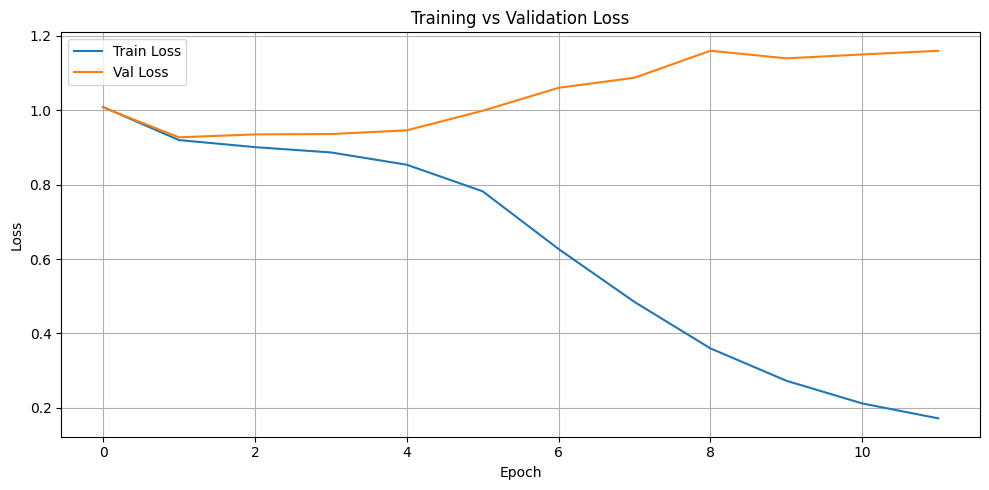

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_train, label='Train Loss')
plt.plot(history_val, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class DenormalizedModel(nn.Module):
    def __init__(self, base_model, mean, std):
        super().__init__()
        self.base_model = base_model
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def forward(self, x):
        out = self.base_model(x)
        return out * self.std + self.mean

In [ ]:
model = torch.load("helyx_model_normalized.pt")
stats = torch.load("label_stats.pt")

# Model and parameters
model = model.to(device)
mean = stats['mean'].to(device)
std = stats['std'].to(device)

# Save final model
final_model = DenormalizedModel(model, mean, std)
torch.save(final_model, "helyx_model.pt")

del final_model
del stats

## ⏰ Testing

Progress: 15.8%

Test MSE (normalized): 0.8855
Test MSE: 179.7844


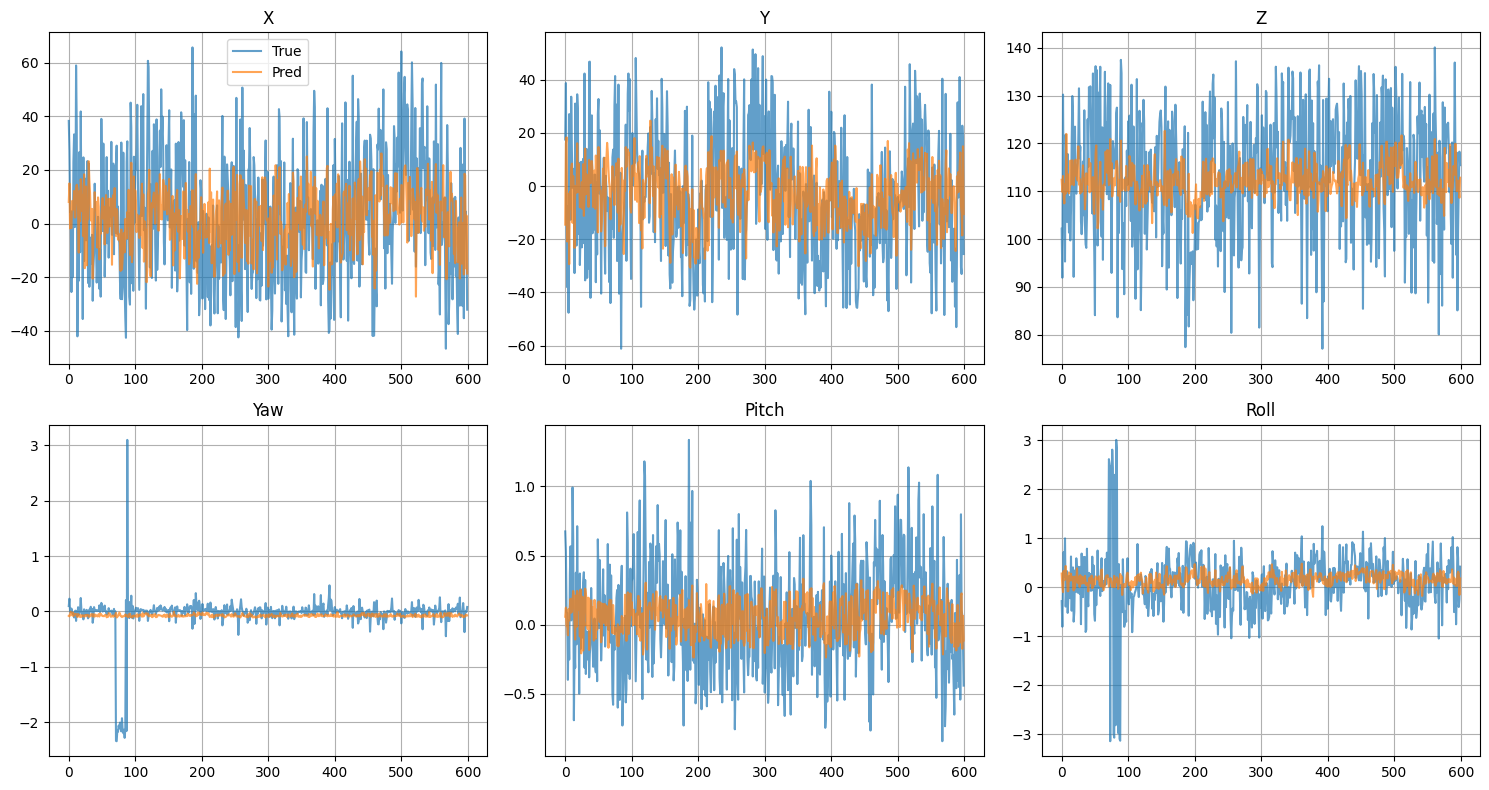

In [ ]:
# Load full model
model = torch.load("helyx_model.pt")
model_normalized = torch.load("helyx_model_normalized.pt")
stats = torch.load("label_stats.pt")
mean = stats['mean'].to(device)
std = stats['std'].to(device)
model = model.to(device)
model_normalized = model_normalized.to(device)
model.eval()
model_normalized.eval()

all_preds = []
all_preds_normalized = []
all_labels = []
all_labels_normalized = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_normalized = (labels - mean) / std

        preds = model(images)
        preds_normalized = model_normalized(images)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_preds_normalized.append(preds_normalized.cpu().numpy())
        all_labels_normalized.append(labels_normalized.cpu().numpy())
        progress = (i + 1) / len(test_loader) * 100
        sys.stdout.write(f"\rProgress: {progress:.1f}%")
        sys.stdout.flush()
        del images, labels, preds, preds_normalized

print("\n")

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds_normalized = np.concatenate(all_preds_normalized, axis=0)
all_labels_normalized = np.concatenate(all_labels_normalized, axis=0)

mse = np.mean((all_preds - all_labels) ** 2)
mse_normalized = np.mean((all_preds_normalized - all_labels_normalized) ** 2)
print(f"Test MSE (normalized): {mse_normalized:.4f}")
print(f"Test MSE: {mse:.4f}")

param_names = ['X', 'Y', 'Z', 'Yaw', 'Pitch', 'Roll']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.flatten()):
    ax.plot(all_labels[:, i], label='True', alpha=0.7)
    ax.plot(all_preds[:, i], label='Pred', alpha=0.7)
    ax.set_title(param_names[i])
    ax.grid(True)

axes[0, 0].legend()
plt.tight_layout()
plt.show()